# MRI Image Processing for Brain Disease Analysis
### By: Wong Zi Ning

In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras import layers, models, metrics, applications
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [2]:
train_set = keras.preprocessing.image_dataset_from_directory(
   "C:/Users/user/Downloads/archive/Training",
    labels='inferred',  # Automatically infer labels from subdirectory names
    label_mode='int',
    interpolation='nearest',
    batch_size=32,
    image_size=(256,256)
)

test_set = keras.preprocessing.image_dataset_from_directory(
    "C:/Users/user/Downloads/archive/Testing",
    labels='inferred',  # Automatically infer labels from subdirectory names
    label_mode='int',
    interpolation='nearest',
    batch_size=32,
    image_size=(256,256)
)

Found 5712 files belonging to 4 classes.
Found 1310 files belonging to 4 classes.


In [3]:
class_names = train_set.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [4]:
train_set = train_set.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
test_set = test_set.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

In [5]:
# prompt: get the number of samples in test and train set

num_train_samples = 0
for batch in train_set:
    num_train_samples += batch[0].shape[0]

num_test_samples = 0
for batch in test_set:
    num_test_samples += batch[0].shape[0]

print("Number of training samples:", num_train_samples)
print("Number of testing samples:", num_test_samples)

Number of training samples: 5712
Number of testing samples: 1310


In [6]:
# prompt: view the info of the train_set and test_set

print(train_set)
test_set

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

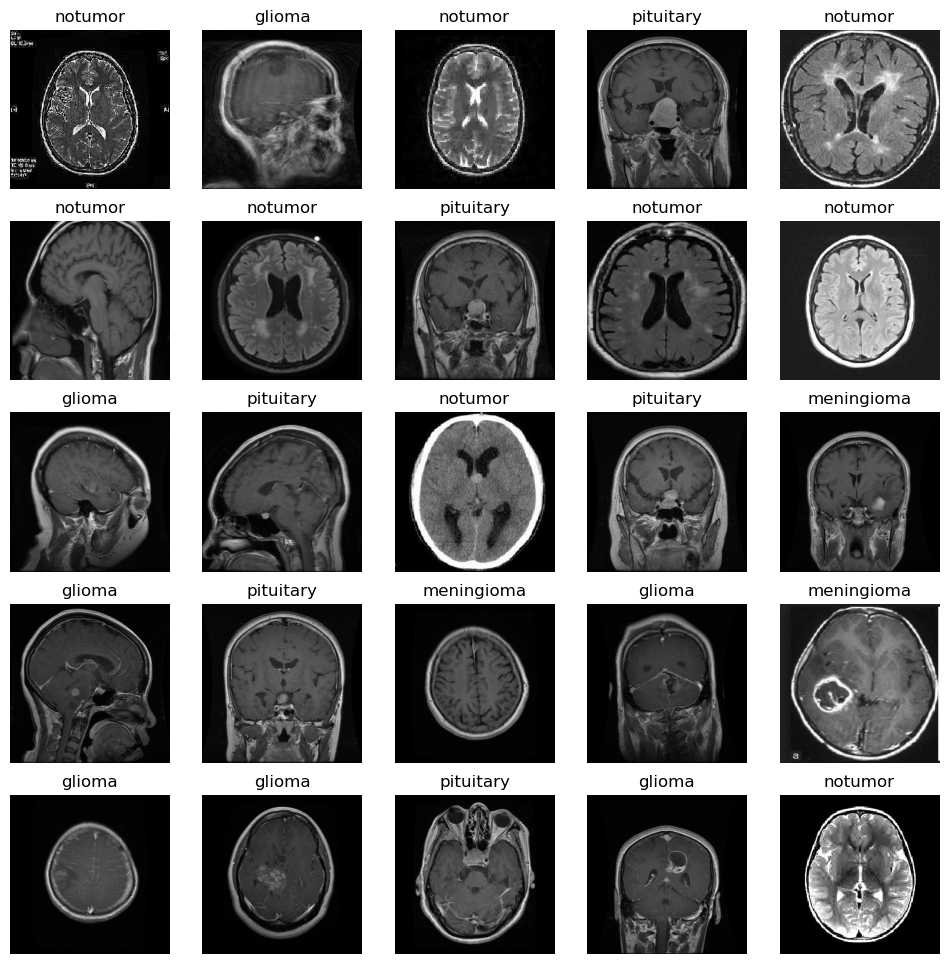

In [7]:
plt.figure(figsize=(12,12))
for img, label in train_set.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title(class_names[label[i]])
        plt.axis('off')

In [8]:
# Convert the TensorFlow Dataset to NumPy arrays
X_test = []
y_test = []
for images, labels in test_set:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Split the test set into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

# Convert the NumPy arrays back to TensorFlow Datasets
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(32)
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)


In [9]:
# get the number of images based on the class names

image_counts = {}
for class_name in class_names:
  class_dir = os.path.join("C:/Users/user/Downloads/archive/Training", class_name)
  image_count = len(os.listdir(class_dir))
  image_counts[class_name] = image_count

for class_name, count in image_counts.items():
  print(f"Class: {class_name}, Number of images: {count}")

Class: glioma, Number of images: 1321
Class: meningioma, Number of images: 1339
Class: notumor, Number of images: 1595
Class: pituitary, Number of images: 1457


In [10]:
image_counts = {}
for class_name in class_names:
  class_dir = os.path.join("C:/Users/user/Downloads/archive/Testing", class_name)
  image_count = len(os.listdir(class_dir))
  image_counts[class_name] = image_count

for class_name, count in image_counts.items():
  print(f"Class: {class_name}, Number of images: {count}")

Class: glioma, Number of images: 300
Class: meningioma, Number of images: 306
Class: notumor, Number of images: 404
Class: pituitary, Number of images: 300


In [11]:
# Combine the datasets
combined_dataset = train_set.concatenate(test_set)

# You can now iterate through the combined dataset
# Example: Print the shapes of the first batch
for image_batch, label_batch in combined_dataset.take(1):
  print("Image batch shape:", image_batch.shape)
  print("Label batch shape:", label_batch.shape)

#Further processing or storage of combined_dataset
#Example: Convert to NumPy arrays for easier manipulation if needed
images = []
labels = []

for image_batch, label_batch in combined_dataset:
    images.extend(image_batch.numpy())
    labels.extend(label_batch.numpy())

#Now images and labels are NumPy arrays containing all the data.
images = np.array(images)
labels = np.array(labels)
print("Total number of Image and labels:",images.shape, labels.shape)

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)
Total number of Image and labels: (6367, 256, 256, 3) (6367,)


In [12]:
print("Labels and their corresponding numerical values:")
for i, class_name in enumerate(class_names):
  print(f"{i}: {class_name}")

Labels and their corresponding numerical values:
0: glioma
1: meningioma
2: notumor
3: pituitary


In [13]:
# Create a DataFrame
df = pd.DataFrame({'image': list(images), 'label': list(labels)})

# Print the DataFrame (or perform other operations)
print(df.info()) # Print the first few rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6367 entries, 0 to 6366
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   6367 non-null   object
 1   label   6367 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 74.7+ KB
None


In [14]:
input_shape = images.shape[1:]  # Get the shape of your images
num_classes = len(np.unique(labels))  # Get the number of unique classes

print(input_shape)
print(num_classes)

(256, 256, 3)
4


## Model Training


### GoogleNet (InceptionV3)

In [15]:
# Load pre-trained InceptionV3 model (excluding the top classification layer)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(len(class_names), activation='softmax')(x)

# Create the final model
model_v3 = models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_v3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_v3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [16]:
history = model_v3.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 422ms/step - accuracy: 0.7336 - loss: 0.8599 - val_accuracy: 0.8260 - val_loss: 0.5083
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.8870 - loss: 0.3089 - val_accuracy: 0.8611 - val_loss: 0.3515
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.9144 - loss: 0.2249 - val_accuracy: 0.8641 - val_loss: 0.3516
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.9332 - loss: 0.1670 - val_accuracy: 0.8855 - val_loss: 0.2525
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9409 - loss: 0.1509 - val_accuracy: 0.8901 - val_loss: 0.3169
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.9485 - loss: 0.1233 - val_accuracy: 0.9145 - val_loss: 0.2213
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.9554 - loss: 0.1127 - val_accuracy: 0.9298 - val_loss: 0.2018
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.9742 - loss: 0.0775 - val_ac

In [17]:
# Evaluate the model
loss, accuracy = model_v3.evaluate(test_set)

# Print the results with 4 decimal places
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


21/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9355 - loss: 0.2224
Test Loss: 0.2118
Test Accuracy: 93.59%


21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
              precision    recall  f1-score   support

      glioma       0.99      0.84      0.91       150
  meningioma       0.84      0.92      0.88       153
     notumor       0.98      1.00      0.99       202
   pituitary       0.94      0.96      0.95       150

    accuracy                           0.94       655
   macro avg       0.94      0.93      0.93       655
weighted avg       0.94      0.94      0.94       655



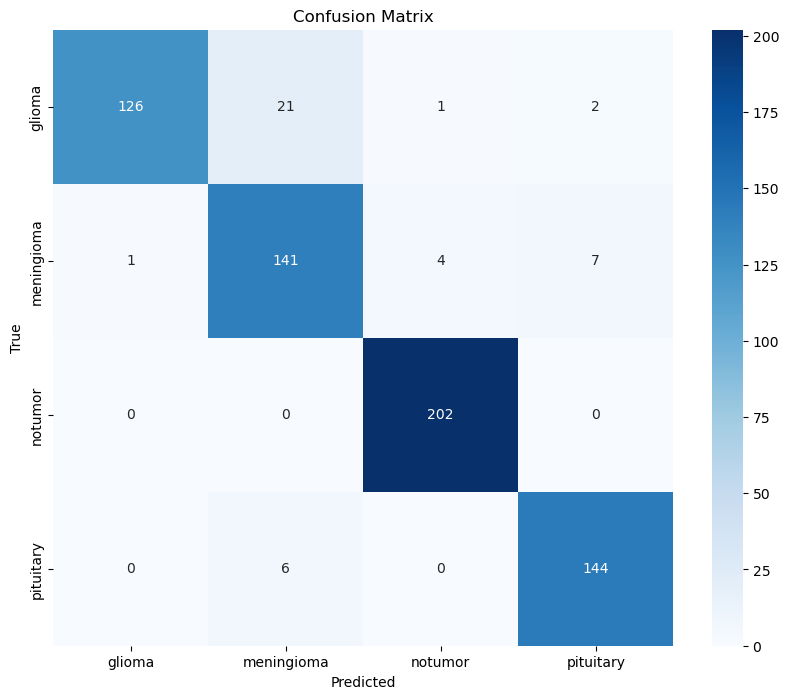

In [18]:
# classification report and confusion matrix

# Make predictions on the test set
y_pred = model_v3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Generate the classification report
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Generate and plot the confusion matrix
conf_matrix2 = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### VGG-19

In [19]:
# Load pre-trained VGG-19 model (excluding the top classification layer)
base_model = applications.VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(class_names), activation='softmax')(x)

# Create the final model
model_vgg = models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_vgg.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

model_vgg.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 38,923,332 (148.48 MB)

 Trainable params: 18,898,948 (72.09 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [20]:
history_vgg = model_vgg.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1850s 10s/step - accuracy: 0.5094 - loss: 1.3952 - val_accuracy: 0.7328 - val_loss: 0.6743
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - accuracy: 0.7566 - loss: 0.5821 - val_accuracy: 0.7802 - val_loss: 0.5930
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.7942 - loss: 0.5052 - val_accuracy: 0.7924 - val_loss: 0.5632
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.8167 - loss: 0.4758 - val_accuracy: 0.7893 - val_loss: 0.5704
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.8073 - loss: 0.4907 - val_accuracy: 0.8412 - val_loss: 0.4698
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.8184 - loss: 0.4653 - val_accuracy: 0.8290 - val_loss: 0.4735
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.8193 - loss: 0.4503 - val_accuracy: 0.7847 - val_loss: 0.5496
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.8093 - loss: 0.4830 - val_ac

In [21]:
# Evaluate the model
loss2, accuracy2 = model_vgg.evaluate(test_set)

# Print the results with 4 decimal places
print(f"Test Loss: {loss2:.4f}")
print(f"Test Accuracy: {accuracy2 * 100:.2f}%")


21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7965 - loss: 0.4738
Test Loss: 0.4484
Test Accuracy: 82.14%


21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step
              precision    recall  f1-score   support

      glioma       0.92      0.72      0.81       150
  meningioma       0.67      0.63      0.65       153
     notumor       0.90      0.94      0.92       202
   pituitary       0.79      0.96      0.87       150

    accuracy                           0.82       655
   macro avg       0.82      0.81      0.81       655
weighted avg       0.82      0.82      0.82       655



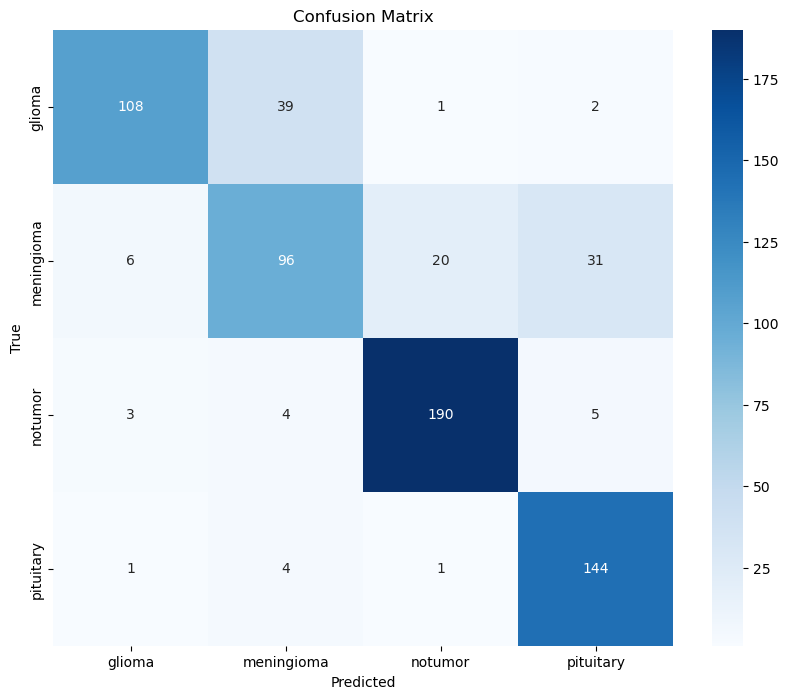

In [22]:
# Make predictions on the test set
y_pred_vgg = model_vgg.predict(X_test)
y_pred_classes_vgg = np.argmax(y_pred_vgg, axis=1)  # Convert probabilities to class labels

# Generate the classification report
print(classification_report(y_test, y_pred_classes_vgg, target_names=class_names))

# Generate and plot the confusion matrix
conf_matrix_vgg = confusion_matrix(y_test, y_pred_classes_vgg)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Inception-Multiscale CNN

In [23]:
# Define the Multiscale CNN model
input_layer = layers.Input(shape=(256, 256, 3))

# Scale 1: Small-scale features with 3x3 kernels
conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
pool1 = layers.MaxPooling2D((2, 2))(conv1)

# Scale 2: Larger-scale features with 5x5 kernels
conv2 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(input_layer)
pool2 = layers.MaxPooling2D((2, 2))(conv2)

# Scale 3: Largest-scale features with 7x7 kernels
conv3 = layers.Conv2D(32, (7, 7), activation='relu', padding='same')(input_layer)
pool3 = layers.MaxPooling2D((2, 2))(conv3)

# Concatenate the outputs of different scales
merged = layers.concatenate([pool1, pool2, pool3])

# Further convolutional layers
conv4 = layers.Conv2D(64, (3, 3), activation='relu')(merged)
pool4 = layers.MaxPooling2D((2, 2))(conv4)

conv5 = layers.Conv2D(128, (3, 3), activation='relu')(pool4)
pool5 = layers.MaxPooling2D((2, 2))(conv5)

# Flatten and Dense layers
flatten = layers.Flatten()(pool5)
dense1 = layers.Dense(128, activation='relu')(flatten)
output = layers.Dense(len(class_names), activation='softmax')(dense1)  # Output layer

# Define the model
multiscale_model = models.Model(inputs=input_layer, outputs=output)

# Compile the model
multiscale_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

multiscale_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 256, 256,  │      2,432 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 256, 256,  │      4,736 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_94[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 128, 128,  │          0 │ conv2d_95[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 128,  │          0 │ conv2d_96[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ max_pooling2d_4[… │
│ (Concatenate)       │ 96)               │            │ max_pooling2d_5[… │
│                     │                   │            │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 126, 126,  │     55,360 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 63, 63,    │          0 │ conv2d_97[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 61, 61,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 30, 30,    │          0 │ conv2d_98[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 115200)    │          0 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │ 14,745,728 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 4)         │        516 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,883,524 (56.78 MB)

 Trainable params: 14,883,524 (56.78 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history3 = multiscale_model.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 180s 996ms/step - accuracy: 0.6214 - loss: 1.0115 - val_accuracy: 0.7435 - val_loss: 0.6783
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 177s 990ms/step - accuracy: 0.8847 - loss: 0.2981 - val_accuracy: 0.9008 - val_loss: 0.2739
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 179s 999ms/step - accuracy: 0.9433 - loss: 0.1678 - val_accuracy: 0.9221 - val_loss: 0.2114
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 178s 994ms/step - accuracy: 0.9696 - loss: 0.0899 - val_accuracy: 0.9450 - val_loss: 0.1735
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 179s 998ms/step - accuracy: 0.9845 - loss: 0.0454 - val_accuracy: 0.9328 - val_loss: 0.2462
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 179s 999ms/step - accuracy: 0.9912 - loss: 0.0285 - val_accuracy: 0.9221 - val_loss: 0.3809
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 178s 994ms/step - accuracy: 0.9846 - loss: 0.0419 - val_accuracy: 0.9466 - val_loss: 0.2309
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 179s 997ms/step - accuracy: 0.9943 -

In [25]:
# Evaluate the model
loss3, accuracy3 = multiscale_model.evaluate(test_set)

# Print the results with 4 decimal places
print(f"Test Loss: {loss3:.4f}")
print(f"Test Accuracy: {accuracy3 * 100:.2f}%")


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.9616 - loss: 0.1447
Test Loss: 0.1284
Test Accuracy: 96.79%


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step
              precision    recall  f1-score   support

      glioma       0.97      0.92      0.95       150
  meningioma       0.92      0.95      0.94       153
     notumor       0.99      1.00      0.99       202
   pituitary       0.99      0.99      0.99       150

    accuracy                           0.97       655
   macro avg       0.97      0.97      0.97       655
weighted avg       0.97      0.97      0.97       655



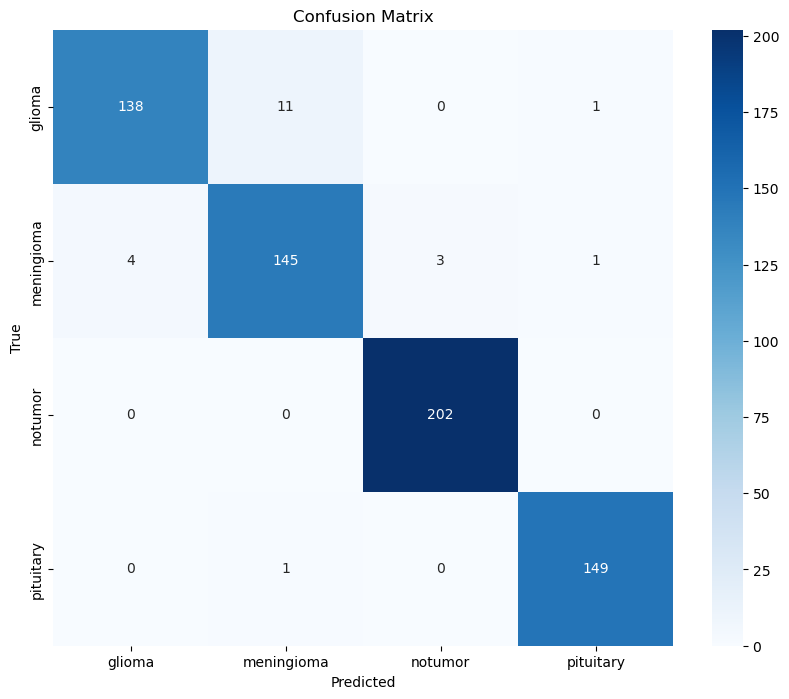

In [26]:
# Make predictions on the test set
y_pred3 = multiscale_model.predict(X_test)
y_pred_classes3 = np.argmax(y_pred3, axis=1)  # Convert probabilities to class labels

# Generate the classification report
print(classification_report(y_test, y_pred_classes3, target_names=class_names))

# Generate and plot the confusion matrix
conf_matrix3 = confusion_matrix(y_test, y_pred_classes3)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix3, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Summary

In [27]:
print("Test Accuracy")
print("=======================")
print(f"GoogleNet (Inception V3): {accuracy * 100:.2f}%")
print(f"VGG-19: {accuracy2 * 100:.2f}%")
print(f"Multiscale CNN: {accuracy3 * 100:.2f}%")

Test Accuracy
GoogleNet (Inception V3): 93.59%
VGG-19: 82.14%
Multiscale CNN: 96.79%


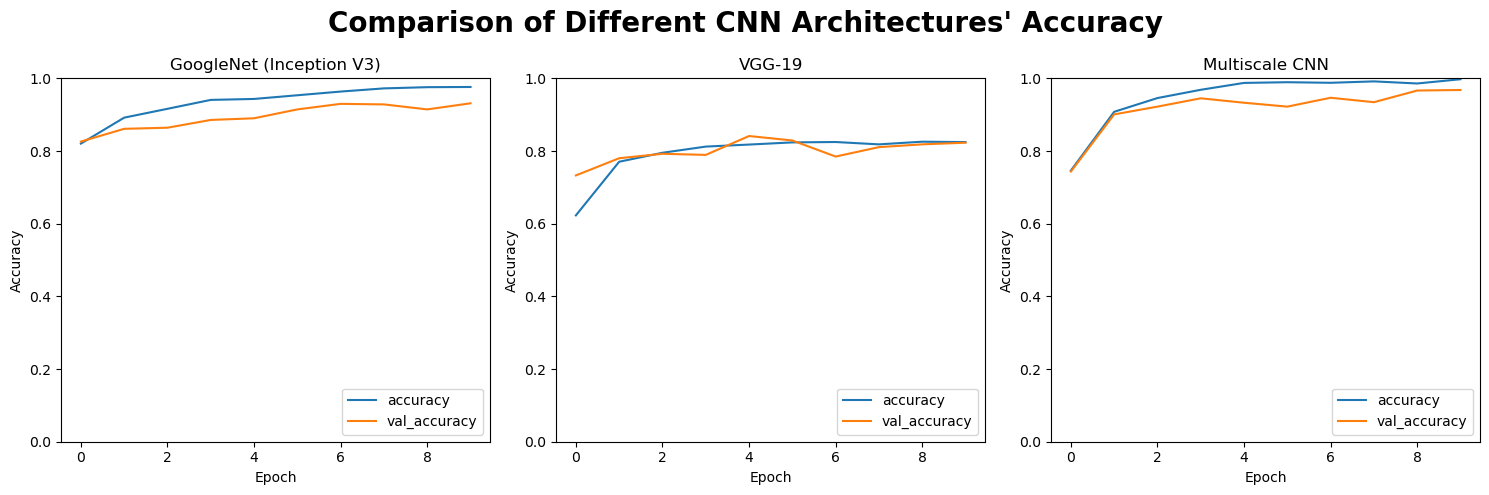

In [28]:
# Create a figure with 1 row and 3 columns
plt.figure(figsize=(15, 5))

# Add a big title for the entire figure
plt.suptitle("Comparison of Different CNN Architectures' Accuracy", fontsize=20, fontweight='bold')

# Plot the first graph
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("GoogleNet (Inception V3)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Plot the second graph
plt.subplot(1, 3, 2)
plt.plot(history_vgg.history['accuracy'], label='accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='val_accuracy')
plt.title("VGG-19")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Plot the third graph
plt.subplot(1, 3, 3)
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label='val_accuracy')
plt.title("Multiscale CNN")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Adjust the layout to make sure everything fits
plt.tight_layout()

# Show the plots
plt.show()


In [29]:
print("Test Lost")
print("=======================")
print("GoogleNet:",loss)
print("VGG-19:",loss2)
print("Multiscale CNN: ",loss3)

Test Lost
GoogleNet: 0.21181026101112366
VGG-19: 0.44836780428886414
Multiscale CNN:  0.12839944660663605


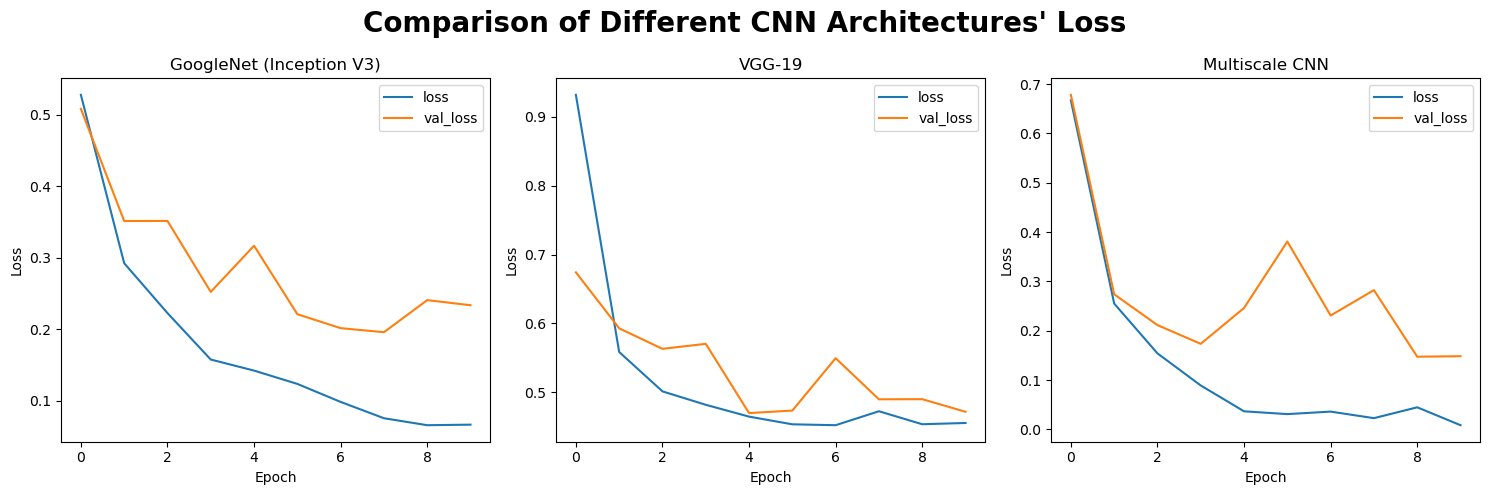

In [30]:
# Create a figure with 1 row and 3 columns
plt.figure(figsize=(15, 5))

# Add a big title for the entire figure
plt.suptitle("Comparison of Different CNN Architectures' Loss", fontsize=20, fontweight='bold')

# Plot the first graph
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("GoogleNet (Inception V3)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot the second graph
plt.subplot(1, 3, 2)
plt.plot(history_vgg.history['loss'], label='loss')
plt.plot(history_vgg.history['val_loss'], label='val_loss')
plt.title("VGG-19")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot the third graph
plt.subplot(1, 3, 3)
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label='val_loss')
plt.title("Multiscale CNN")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Adjust the layout to make sure everything fits
plt.tight_layout()

# Show the plots
plt.show()


In [31]:
multiscale_model.save("MRI_model.keras")

## Deployment

In [32]:
def predict(img_paths, actual_labels=None):
    if actual_labels is None:
        actual_labels = ["Unknown"] * len(img_paths)  # Default label if not provided

    for img_path, actual_label in zip(img_paths, actual_labels):
        # Ensure class names match training labels
        label = list(class_names)

        # Load and preprocess the image
        img = tf.keras.utils.load_img(img_path, target_size=(256, 256))  # Resize
        img = tf.keras.utils.img_to_array(img)  # Convert to array
        img = img / 255.0 
        img = tf.expand_dims(img, axis=0)  # Add batch dimension
        img = tf.convert_to_tensor(img)  # Convert to TensorFlow tensor

        # Prediction
        predictions = multiscale_model.predict(img)
        probs = predictions[0].tolist()  # Convert to list
        predicted_class = label[np.argmax(probs)]  # Get highest probability class

        # Print prediction details
        print(f"\nImage: {img_path}")
        print("Predicted probabilities:", probs)
        print(f"Actual Label: {actual_label}")
        print(f"Predicted Label: {predicted_class}")

        # Plot image with title
        plt.figure(figsize=(6, 6))
        plt.imshow(Image.open(img_path), cmap="gray")
        plt.axis("off")

        # Title with actual and predicted label
        plt.title(f"Actual Label: {actual_label}\nPredicted Label: {predicted_class}", 
                  fontsize=12, weight="bold")

        # Plot probability distribution
        plt.figure(figsize=(6, 3))
        bars = plt.barh(label, probs, color="gray")
        plt.xlabel("Probability", fontsize=12)
        ax = plt.gca()
        ax.bar_label(bars, fmt="%.2f")

        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Image: C:/Users/user/Downloads/archive/Testing/glioma/Te-gl_0260.jpg
Predicted probabilities: [0.9896975159645081, 0.010299714282155037, 1.3230006743469858e-06, 1.505728391748562e-06]
Actual Label: glioma
Predicted Label: glioma


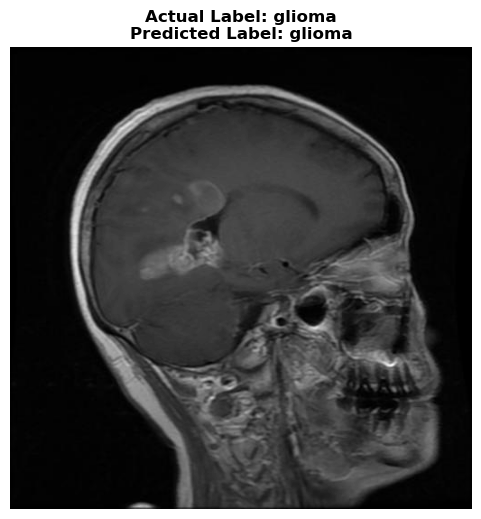

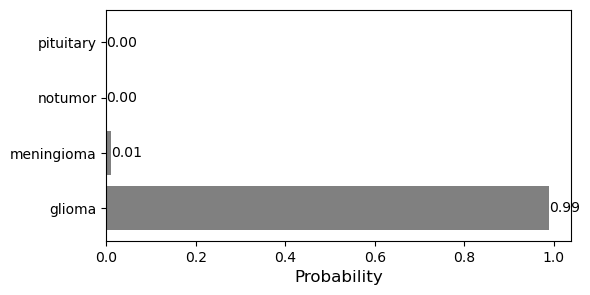

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Image: C:/Users/user/Downloads/archive/Testing/notumor/Te-no_0335.jpg
Predicted probabilities: [5.396780637938366e-15, 1.5370369421674468e-09, 1.0, 6.643567264168646e-17]
Actual Label: notumor
Predicted Label: notumor


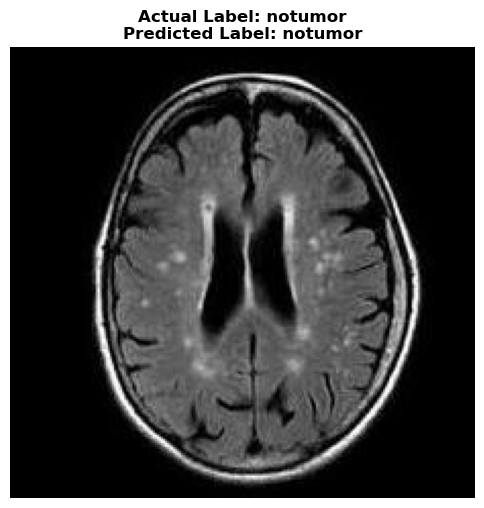

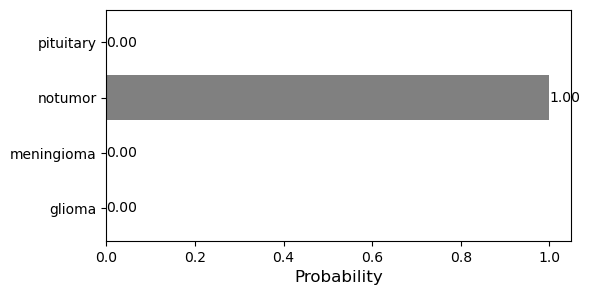

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Image: C:/Users/user/Downloads/archive/Testing/pituitary/Te-pi_0278.jpg
Predicted probabilities: [3.312053650006419e-06, 2.852024181265733e-07, 6.192672117322218e-06, 0.9999902248382568]
Actual Label: pituitary
Predicted Label: pituitary


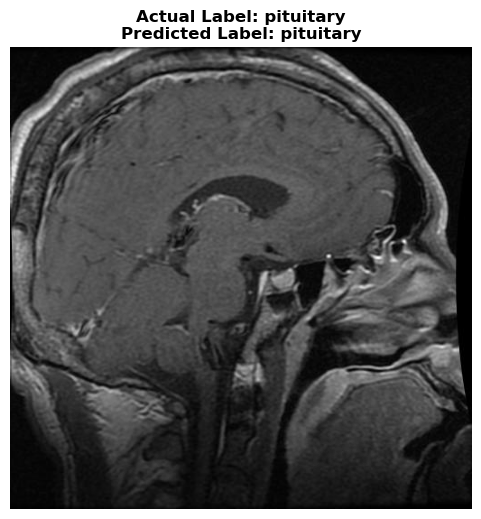

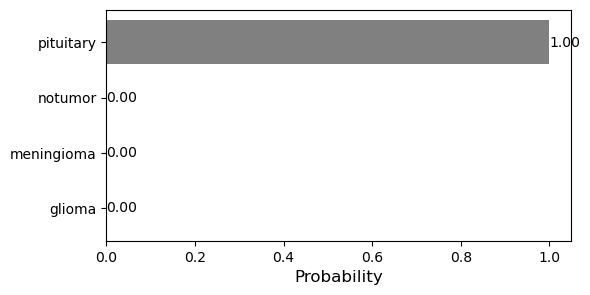

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Image: C:/Users/user/Downloads/archive/Testing/meningioma/Te-me_0225.jpg
Predicted probabilities: [3.7435816921060905e-05, 0.9999618530273438, 7.625392868249037e-07, 1.576280972415134e-08]
Actual Label: meningioma
Predicted Label: meningioma


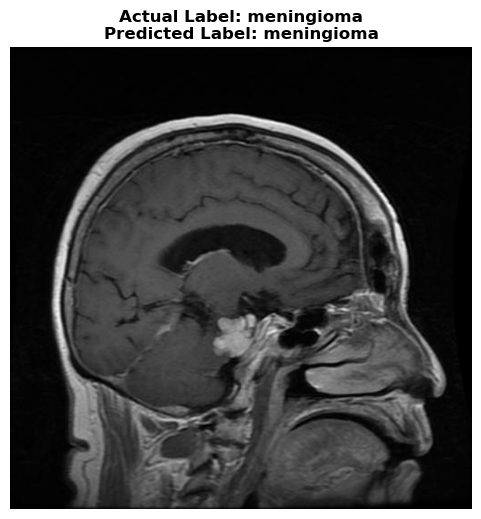

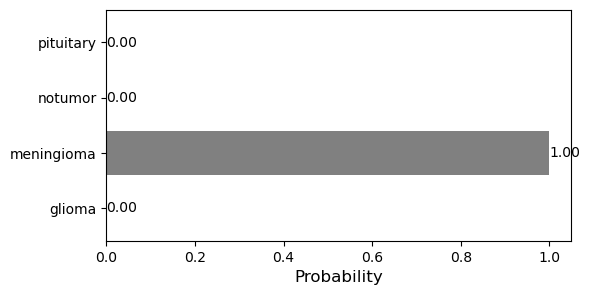

In [33]:
# Example usage
img_paths = [
    "C:/Users/user/Downloads/archive/Testing/glioma/Te-gl_0260.jpg",
    "C:/Users/user/Downloads/archive/Testing/notumor/Te-no_0335.jpg",
    "C:/Users/user/Downloads/archive/Testing/pituitary/Te-pi_0278.jpg",
    "C:/Users/user/Downloads/archive/Testing/meningioma/Te-me_0225.jpg"
]

actual_labels = ["glioma","notumor","pituitary",  "meningioma"]  # Actual labels for reference
predict(img_paths, actual_labels)